In [1]:
import sys
import argparse
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os
import time
import json
from keras import backend as K
K.set_learning_phase(1)
from keras.models import model_from_json
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.models import model_from_json
import types
from IPython.display import Image as PyImage
from IPython.core.display import HTML

Using TensorFlow backend.


In [2]:
target_size = (229, 229) 

In [3]:
def load_prediction_model(args):
    try:
        print (args.config_file[0]) 
        with open(args.config_file[0]) as json_file:
              model_json = json_file.read()
        model = model_from_json(model_json)
    except:
          print ("Please specify a model configuration file ...")
          sys.exit(1)
    try:
          model.load_weights(args.weights_file[0])
          print ("Loaded model weights from: " + str(args.weights_file[0]))
    except:
          print ("Error loading model weights ...")
          sys.exit(1)
    try:
        print (args.labels_file[0])
        with open(args.labels_file[0]) as json_file:
            labels = json.load(json_file)
        print ("Loaded labels from: " + str(args.labels_file[0]))
    except:
        print ("No labels loaded ...")
        sys.exit(1)
    #compile_model(model)
    return model, labels

In [4]:
args = types.SimpleNamespace()
args.config_file = ['/home/rahul/ICIAR/model_22.json']
args.weights_file = ['/home/rahul/ICIAR/trained_weights_22.model']
args.labels_file = ['/home/rahul/ICIAR/trained_labels.json']
args.output_dir = ['/home/rahul/']

In [5]:
model, labels = load_prediction_model(args)

/home/rahul/ICIAR/model_22.json
Loaded model weights from: /home/rahul/ICIAR/trained_weights_22.model
/home/rahul/ICIAR/trained_labels.json
Loaded labels from: /home/rahul/ICIAR/trained_labels.json


In [6]:
from keras.utils import plot_model 
import pydot 
import graphviz # apt-get install -y graphviz libgraphviz-dev 
from IPython.display import SVG 
from keras.utils.vis_utils import model_to_dot

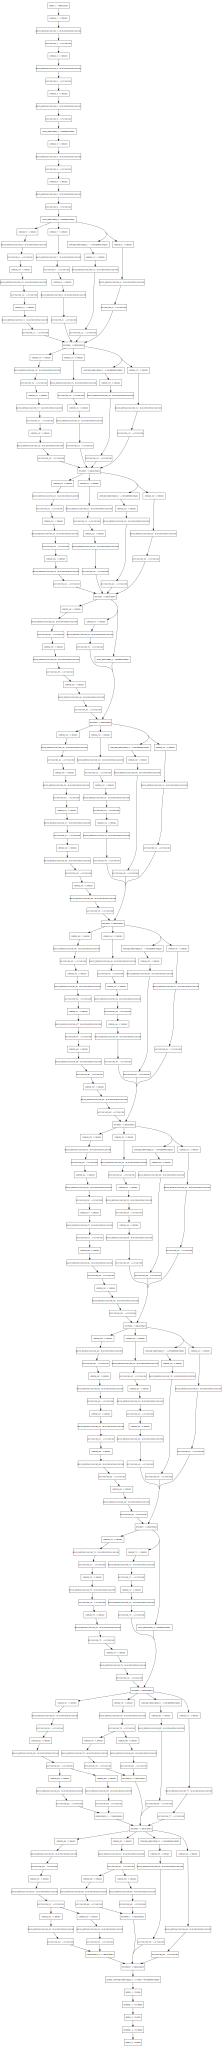

In [7]:
plot_model(model, to_file='model.png') 
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
args.image = ['/home/rahul/ICIAR/09.jpg']
img = Image.open(args.image[0])

In [9]:
def input_to_tensor(img, target_size):
  if img.size != target_size:
    img = img.resize(target_size)

  _x_ = image.img_to_array(img)
  _x_ = np.expand_dims(_x_, axis=0)
  _x_ = preprocess_input(_x_)
  return (_x_)

In [10]:
def generate_loss(model, layer_name, filter_index):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer_output = layer_dict[layer_name].output
    print ('Output layer dimensions = ' + str(layer_output.shape))
    loss = K.mean(layer_output[:, filter_index])
    return loss

In [11]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 0, 2))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [12]:
def image_process(loss, model, input_img_data, step = 1.):
    input_img = model.input
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

     # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    step = step
    for i in range(20):
        print ('Processing ' + str(i+1) + ' out of 20')
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img_proc = input_img_data[0]
    img_proc = deprocess_image(img_proc)
    return img_proc

In [13]:
layer_name = 'conv2d_76'
filter_index = 0
loss = generate_loss(model, layer_name, filter_index)
input_img_data = input_to_tensor(img, target_size)
img_proc = image_process(loss, model, input_img_data, step = 1.)
imsave('%s_filter_%d.png' % (layer_name, filter_index), img_proc)
img_in = img.resize(target_size)
imsave('%s_%s.png' % ('input_img', layer_name),img_in)

Output layer dimensions = (?, ?, ?, 192)
Processing 1 out of 20
Processing 2 out of 20
Processing 3 out of 20
Processing 4 out of 20
Processing 5 out of 20
Processing 6 out of 20
Processing 7 out of 20
Processing 8 out of 20
Processing 9 out of 20
Processing 10 out of 20
Processing 11 out of 20
Processing 12 out of 20
Processing 13 out of 20
Processing 14 out of 20
Processing 15 out of 20
Processing 16 out of 20
Processing 17 out of 20
Processing 18 out of 20
Processing 19 out of 20
Processing 20 out of 20


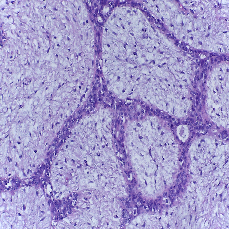

In [14]:
PyImage('%s_%s.png' % ('input_img', layer_name))

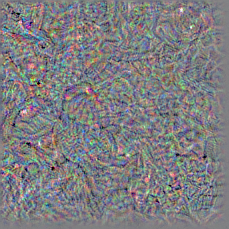

In [15]:
PyImage('%s_filter_%d.png' % (layer_name, filter_index))

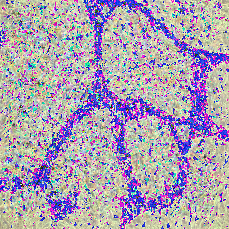

In [16]:
img_diff = img_proc-img_in
imsave('%s_%s.png' % ('diff_img', layer_name), img_diff)
PyImage('%s_%s.png' % ('diff_img', layer_name))

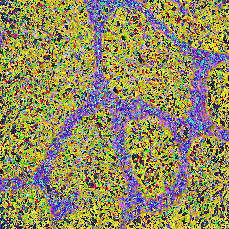

In [17]:
heat_img = (img_in-img_diff)
imsave('%s_%s.png' % ('heatmap', layer_name), heat_img)
PyImage('%s_%s.png' % ('heatmap', layer_name))

In [18]:
layer_name = 'dense_3'
filter_index = 1
loss = generate_loss(model, layer_name, filter_index)
input_img_data = input_to_tensor(img, target_size)
img_proc = image_process(loss, model, input_img_data, step = 1.)
imsave('%s_filter_%d.png' % (layer_name, filter_index), img_proc)
img_in = img.resize(target_size)
imsave('%s_%s.png' % ('input_img', layer_name),img_in)

Output layer dimensions = (?, 4)
Processing 1 out of 20
Processing 2 out of 20
Processing 3 out of 20
Processing 4 out of 20
Processing 5 out of 20
Processing 6 out of 20
Processing 7 out of 20
Processing 8 out of 20
Processing 9 out of 20
Processing 10 out of 20
Processing 11 out of 20
Processing 12 out of 20
Processing 13 out of 20
Processing 14 out of 20
Processing 15 out of 20
Processing 16 out of 20
Processing 17 out of 20
Processing 18 out of 20
Processing 19 out of 20
Processing 20 out of 20


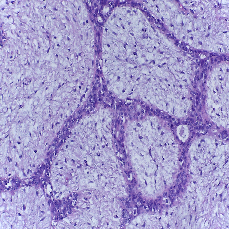

In [19]:
PyImage('%s_%s.png' % ('input_img', layer_name))

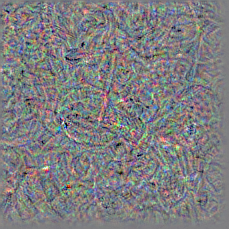

In [20]:
PyImage('%s_filter_%d.png' % (layer_name, filter_index))

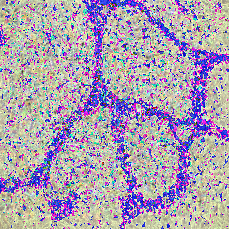

In [21]:
img_diff = img_proc-img_in
imsave('%s_%s.png' % ('diff_img', layer_name), img_diff)
PyImage('%s_%s.png' % ('diff_img', layer_name))

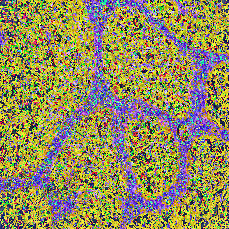

In [22]:
heat_img = (img_in-img_diff)
imsave('%s_%s.png' % ('heatmap', layer_name), heat_img)
PyImage('%s_%s.png' % ('heatmap', layer_name))